<a href="https://colab.research.google.com/github/alonedecio/sam2/blob/main/SAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Certificando de que o SAM 2 está configurado e instalado. Incluindo as bibliotecas necessárias e download do checkpoint.

In [ ]:
# Certifique-se de que `using_colab` está como True
using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt


PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-hu0zhu3z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-hu0zhu3z
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-c

Usando ffmpeg para dividir o vídeo em frames.

In [ ]:
!ffmpeg -i /content/drive/MyDrive/teste_sam2.mp4 -q:v 2 -start_number 0 /content/videos/'%05d.jpg'

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Configurando SAM 2

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor

# Configurações do SAM 2
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

# Configurar dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Usando o dispositivo: {device}")

# Inicializar o modelo
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

# Configurar diretório de frames
video_dir = '/content/videos'
frame_names = [
    p for p in os.listdir(video_dir) if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


Usando o dispositivo: cpu


Identificando um frame chave do vídeo e anotando suas coordenadas para o tracking.

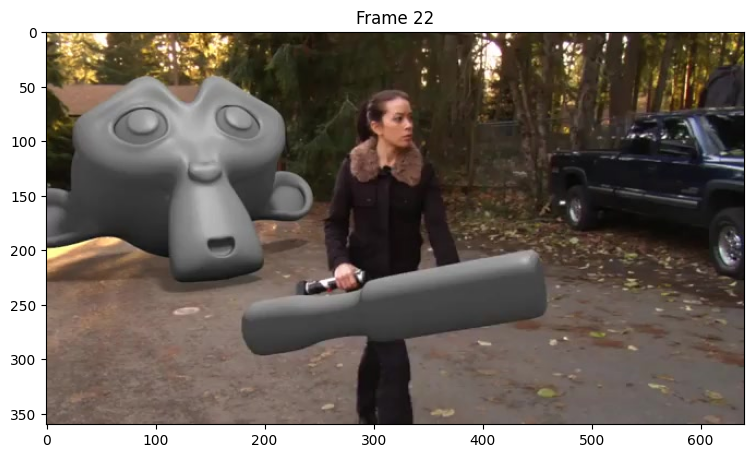

In [ ]:
from PIL import Image

# Mostrar o frame inicial
ann_frame_idx = 22
frame_path = os.path.join(video_dir, frame_names[ann_frame_idx])
frame_image = Image.open(frame_path)

plt.figure(figsize=(9, 6))
plt.title(f"Frame {ann_frame_idx}")
plt.imshow(frame_image)
plt.show()

Inicializando o estado de inferência

In [ ]:
# Inicializar o estado de inferência
inference_state = predictor.init_state(video_path=video_dir)


frame loading (JPEG): 100%|██████████| 396/396 [00:16<00:00, 24.68it/s]


In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    """Exibe a máscara em um eixo de matplotlib."""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
    """Exibe pontos positivos e negativos em um eixo de matplotlib."""
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

/usr/local/lib/python3.10/dist-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/usr/local/lib/python3.10/dist-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


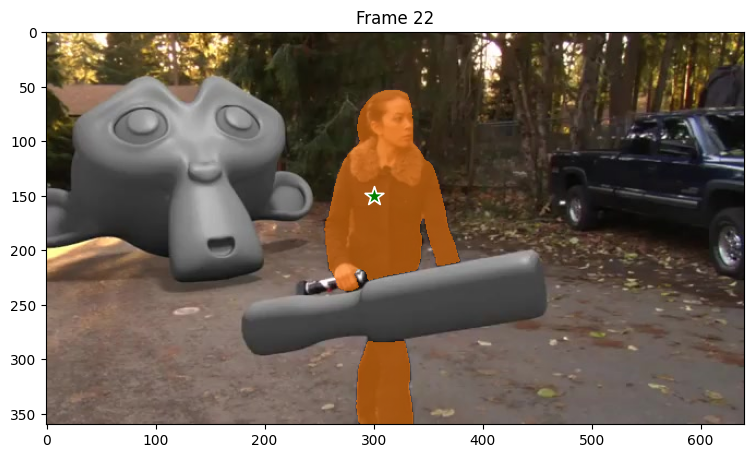

In [ ]:
# Frame inicial para interação
ann_frame_idx = 22
ann_obj_id = 1  # ID único para o objeto (mulher)

# Coordenadas do clique positivo (x, y)
x_coord = 300  # Coordenada X
y_coord = 150  # Coordenada Y

# Coordenadas do clique positivo (x, y) - ajuste conforme o frame inicial
points = np.array([[x_coord, y_coord]], dtype=np.float32)  # Substitua x_coord, y_coord
labels = np.array([1], np.int32)

# Adicionar o clique inicial
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# Mostrar o frame com a máscara inicial
plt.figure(figsize=(9, 6))
plt.title(f"Frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])


In [ ]:
# Propagar para todo o vídeo
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# Visualizar alguns frames com os resultados
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # Check if the frame index exists in video_segments
    if out_frame_idx in video_segments:
        plt.figure(figsize=(6, 4))
        plt.title(f"Frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    else:
        print(f"Skipping frame {out_frame_idx} as it is not in video_segments")

propagate in video:  99%|█████████▉| 370/374 [4:59:14<03:14, 48.73s/it]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Clique adicional para refinar
ann_frame_idx = 150  # Frame para refinar

# Coordenadas do clique positivo (x, y)
x_refine = 310  # Coordenada X
y_refine = 180  # Coordenada Y

points = np.array([[x_refine, y_refine]], dtype=np.float32)  # Substitua por coordenadas
labels = np.array([1], np.int32)

_, _, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# Mostrar o frame refinado
plt.figure(figsize=(9, 6))
plt.title(f"Frame {ann_frame_idx} Refinado")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)


In [ ]:
import cv2

# Salvar como vídeo
output_video_path = "/content/segmented_video.mp4"
height, width = Image.open(os.path.join(video_dir, frame_names[0])).size
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

for frame_idx in range(len(frame_names)):
    frame = np.array(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
    if frame_idx in video_segments:
        for obj_id, mask in video_segments[frame_idx].items():
            mask = (mask * 255).astype(np.uint8)
            # Solução: Remover a primeira dimensão da máscara usando squeeze()
            mask = np.squeeze(mask)
            frame[mask > 0] = [0, 255, 0]  # Cor verde para a máscara
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
out.release()

@article{ravi2024sam2,
  title={SAM 2: Segment Anything in Images and Videos},
  author={Ravi, Nikhila and Gabeur, Valentin and Hu, Yuan-Ting and Hu, Ronghang and Ryali, Chaitanya and Ma, Tengyu and Khedr, Haitham and R{\"a}dle, Roman and Rolland, Chloe and Gustafson, Laura and Mintun, Eric and Pan, Junting and Alwala, Kalyan Vasudev and Carion, Nicolas and Wu, Chao-Yuan and Girshick, Ross and Doll{\'a}r, Piotr and Feichtenhofer, Christoph},
  journal={arXiv preprint arXiv:2408.00714},
  url={https://arxiv.org/abs/2408.00714},
  year={2024}
}